In [1]:
import umap
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from scipy import cluster, spatial, stats
#from dynamicTreeCut import cutreeHybrid, dynamicTreeCut
import seaborn as sns
import networkx as nx
import phenograph
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
import os
import json
from scipy.stats import wasserstein_distance
from pyemd import emd, emd_with_flow
import joblib
#Finished

In [2]:
#calculate distances between cluster centers
cluster_center_file = 'Dictionary/cluster_centers_V3_30binsmanualordered.pkl'
cluster_centers = pd.read_pickle(cluster_center_file)
distmat = np.zeros([len(cluster_centers),len(cluster_centers)])
for i in range(0,len(cluster_centers)):
        for j in range(0,len(cluster_centers)):
            distmat[i,j] = np.linalg.norm(cluster_centers[i]-cluster_centers[j])

<IPython.core.display.Javascript object>


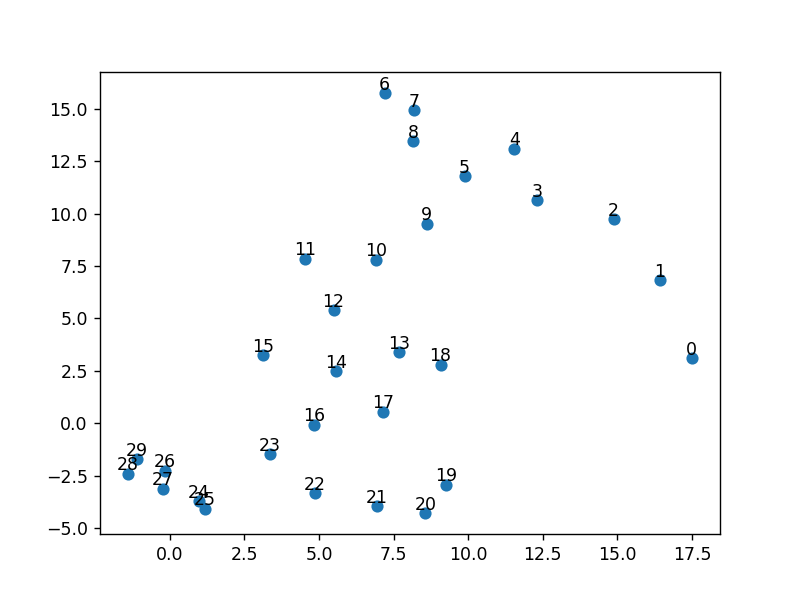

In [3]:
#view points in creature format
reducer = joblib.load(open('../models/pss_dictionary/umap_dictionary_oct2020.pkl', 'rb'))
umap2d = reducer.transform(cluster_centers)
umap2d.shape
xs = umap2d[:,0]
ys = umap2d[:,1]
plt.plot(xs,ys,'o')
index = 0
for x,y in zip(xs,ys):

    label = str(index)
    index+=1

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [4]:
#functions
def calcdistance(x,y):
    #print("This is length of x and y", len(x), " ", len(y))
    inds_was = list(np.where(emd_vec==1)[0])
    inds_euc = list(np.where(emd_vec==0)[0])
    inds_depth = list(np.where(emd_vec==2)[0])
    
    wasx = [x[i] for i in inds_was ]
    wasy = [y[i] for i in inds_was ]
    eucx = [x[i] for i in inds_euc ]
    eucy = [y[i] for i in inds_euc ]
    depx = [x[i] for i in inds_depth ]
    depy = [y[i] for i in inds_depth ]
    
    d1 = np.linalg.norm(np.array(eucx)-np.array(eucy))
    d3 = np.linalg.norm(np.array(depx)-np.array(depy))
    #d4 = np.linalg.norm(np.array(wasx)-np.array(wasy))
    
    #d2 = wasserstein_distance(wasx,wasy)
    d2 = 0
    numbins = int(len(wasx)/30)
    #print(wasx)
    #print(wasy)
    #print(numbins)
    #for i in range(0,30): # distances
    all_earth = []
    all_euc = []
    for i in range(0,16):
        wx = [wasx[j] for j in range(i,len(wasx),16)]
        wy = [wasy[j] for j in range(i,len(wasy),16)]    
        all_earth.append(emd(np.array(wx),np.array(wy),distmat1,extra_mass_penalty=-1.0))
        all_euc.append(np.linalg.norm(np.array(wx)-np.array(wy)))
    #print(wx,wy,ret)
            #d2+= ret
        
    
    return d1,all_earth,d3,all_euc
    
def set_globals(numbins):
    globvars = dict()
    globvars['normalize_by_surfacearea'] = True
    globvars['factor'] = 10000000000
    globvars ['soma_weight'] = 1
    globvars['depth_weight'] = 1
    globvars['pss_weight'] = 1
    globvars['number_of_sholl_bins'] = numbins
    globvars['binsize'] = 15000
    return globvars

def get_dataframe():
    surfaceareadict = {}
    for i in range(0,16):
        key = 'surfacearea_%d'%i
        value = 'surfacearea_%d_to_%d'%(i*15000, (i+1)*15000)
        surfaceareadict[key] = value

    filename_soma = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/basil/auto_basil/auto_basil_features_w_cluster.pkl'
    soma_df = joblib.load(open(filename_soma, 'rb'))
    filename_surfacearea = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/basil/PSS/basil_scholl_surface_areas_full_15mic.pkl'
    surfacearea_df = joblib.load(open(filename_surfacearea, 'rb'))
    surfacearea_df = surfacearea_df.rename(columns=surfaceareadict)
    filename_pss = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/basil/PSS/classification/basil_PSS_histograms.pkl'
    pss_df = joblib.load(open(filename_pss, 'rb'))
    pss_df = pss_df.rename(columns={"id": "soma_id"})

    merge1 = soma_df.merge(surfacearea_df,on='soma_id')
    df = merge1.merge(pss_df,on='soma_id')

    neuron_Tags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16]
    #neuron_df = df.loc[ (df['cluster'].isin(neuron_Tags)) & (df['surface_area'].values > -1)]
    neuron_df = df.loc[ (df['cluster'].isin(neuron_Tags)) ]
    return neuron_df

def get_feature_names(globvars,df):
    featurenames = dict()

    featurenames['soma_features'] = ['soma_synapses', 'soma_area', 'soma_area_to_volume',
           'soma_syn_density', 'soma_volume',
           'nucleus_area_largest', 'nucleus_area_to_volume_largest',
           'nucleus_fold_area_largest', 'nucleus_fract_fold_largest',
           'nucleus_volume_largest',
           'nucleus_to_soma_largest','synapse_size_mean_x','synapse_size_median_x']#'nucleus_avg_depth_largest',

    featurenames['depth_features'] = ['y']

    #maxsholldist = globvars['number_of_sholl_bins']*globvars['binsize']
    maxsholldist = 16*globvars['binsize']
    pss_features = []
    sa_features = []
    for s in df.keys().values:
        tokens = s.split('_')
        featdist = tokens[-1]
        if ('shape' in s) :
            if (int(featdist) <= int(maxsholldist)):
                pss_features.append(s)
                
        if ('surfacearea_' in s):
            if (int(featdist) <= int(maxsholldist)):
                sa_features.append(s)
    featurenames['pss_features'] = pss_features   
    featurenames['surface_area'] = sa_features
    featurenames['tags'] = ['Tags_LE', 'Tags_FC', 'QClabels']

    return featurenames

def calculate_diffs(neuron_df):
    #pss_features = featurenames['pss_features']
    #for i in range(0,len(pss_features)):
    #    mymet = pss_features[i]

    #    tokens = mymet.split('_')
    #    st,distance = tokens[2].split('-')
    #    sval = 'surfacearea_bin_%s'%distance
        
    #    if int(distance) > 15:
    #        prevdistance = int(distance)-15
    #        myprevmet = mymet.replace(distance,str(prevdistance))
    #        neuron_df.loc[:, mymet] = neuron_df.loc[:, mymet]-neuron_df.loc[:, myprevmet]
    #    else:
    #        a = 1
    
    for i in range(15,1,-1):
        mymet = 'surfacearea_%d_to_%d'%(i*15000, (i+1)*15000)
        prevmet = 'surfacearea_%d_to_%d'%((i-1)*15000, i*15000)
        neuron_df.loc[:, mymet]= neuron_df.loc[:, mymet] - neuron_df.loc[:, prevmet]
            

def normalize_by_surface_area(neuron_df,featurenames):
    pss_features = featurenames['pss_features']
    surface_area_features = featurenames['surface_area']
    for pfeat in pss_features:
        pref,distval = pfeat.split('dist_')
        safeat = 'surfacearea_%s'%distval
        origpfeat = 'orig_'+pfeat
        neuron_df.loc[:,origpfeat] = neuron_df.loc[:,pfeat]
        neuron_df.loc[:,pfeat] = neuron_df.loc[:,pfeat]/(neuron_df.loc[:,safeat]+0.0001)
    return neuron_df
        
def calculate_Matrix(globvars,featurenames, neuron_df):
    soma_features = featurenames['soma_features']
    depth_features = featurenames['depth_features']
    pss_features = featurenames['pss_features']
    
    #normalize pss features
    if globvars['normalize_by_surfacearea']:
        neuron_df = normalize_by_surface_area(neuron_df,featurenames)
       
    #select metric values and create matrix M
    mt = []

    for i in range(0,globvars['soma_weight']):
        mt.extend(soma_features)

    numeuc = len(mt)
    for i in range(0,globvars['depth_weight']):
        mt.extend(depth_features)

    
    for i in range(0,globvars['pss_weight']):
        mt.extend(pss_features)

    numtot = len(mt)

    M1,m = normmat(np.array(neuron_df[soma_features].values, dtype=np.float64), 'zscore')
    M2,m = normmat(np.array(neuron_df[depth_features].values, dtype=np.float64), 'zscore')
    #M3,maxs = normmat(np.array(neuron_df[pss_features].values, dtype=np.float64), 'maxscore')
    M3 = np.array(neuron_df[pss_features].values, dtype=np.float64)
    M3 = M3/np.max(M3)
    M = np.concatenate((M1,M2,M3),axis=1)
    maxs=1
    
    ishist = np.ones(numtot)  #value 1 for histogram vectors
    ishist[0:numeuc] = 0      #Leila's features
    ishist[numeuc] = 2        #depth value
    emd_vec = ishist
    
    return M, emd_vec, M3, maxs

def normmat(M,how):
    if how=='zscore':
        means=np.min(M, axis=0)
        stds=np.std(M, axis=0)
        M = (M - means)/stds 
        maxs=0
    else:
        a = 'do nothing'
        #maxs = np.max(M,axis=0)
        #stds=np.std(M, axis=0)
        #M = M/stds
    return M,stds

In [5]:
for numbins in range(16,17):
    distmat1 = (distmat)/np.max(distmat)
    globvars = set_globals(numbins)
    neuron_df = get_dataframe()
    featurenames = get_feature_names(globvars, neuron_df)
    calculate_diffs(neuron_df)
    M,emd_vec,M3,maxs = calculate_Matrix(globvars,featurenames, neuron_df)


    #calculate Distance matrices

    separate = True
    sz = M.shape[0]
    DM_Y = np.zeros((sz,sz))
    DM_D = np.zeros((sz,sz))
    DM_E = np.zeros((sz,sz))
    DM_W = np.zeros((sz,sz,16))
    DM_H = np.zeros((sz,sz,16))

    for i in range(0,sz):
        print(i)
        for j in range(i+1,sz):
            e_val,w_val,d_val,h_val = calcdistance(M[i,:],M[j,:])

            DM_E[i,j] = e_val; DM_E[j,i] = e_val
            DM_D[i,j] = d_val; DM_D[j,i] = d_val
            DM_W[i,j] = w_val; DM_W[j,i] = w_val
            DM_H[i,j] = h_val; DM_H[j,i] = h_val

    myobj = dict()
    myobj['Depth_Matrix'] = DM_D
    myobj['Euclidean'] = DM_E
    myobj['EarthMovers_%dbins'%globvars['number_of_sholl_bins']] = DM_W
    myobj['PSSEuclidean'] = DM_H
    myobj['neuron_df'] = neuron_df
    pickle.dump( myobj, open( "Precalculated_Fixed_Matrices_%dbins_normalized.p"%globvars['number_of_sholl_bins'], "wb" ) )


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
featurenames['pss_features'] 

In [ ]:
e_val,w_val,d_val,h_val = calcdistance(M[i,:],M[j,:])

In [ ]:
print(w_val)

In [ ]:
DM_W[1,0,:]